Attempting to load counts from: /Users/mrrobot/Projects_/EDA_dashboard_GEO_dataset/data/processed/counts_matrix_raw.csv.gz
Attempting to load metadata from: /Users/mrrobot/Projects_/EDA_dashboard_GEO_dataset/data/processed/cell_metadata_basic.csv

Successfully loaded counts_df and basic_metadata_df.
counts_df shape: (23459, 12346)
basic_metadata_df shape: (12346, 3)

Successfully created AnnData object.
AnnData object with n_obs × n_vars = 12346 × 23459
    obs: 'sample_type_prefix', 'tissue_origin', 'patient_id'

Made var_names (gene names) unique.

--- Attempting to identify mitochondrial genes and calculate QC metrics ---
`pct_counts_mt` will be 0. You MUST resolve mitochondrial gene identification for meaningful QC.


/Users/mrrobot/anaconda3/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/mrrobot/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")



Successfully calculated QC metrics.
First 5 rows of adata.obs (cell metadata with QC metrics):
            sample_type_prefix tissue_origin patient_id  n_genes_by_counts  \
NTH10-0616A                NTH   Normal_Lung      0616A               3572   
NTH11-0616A                NTH   Normal_Lung      0616A               3748   
NTH15-0616A                NTH   Normal_Lung      0616A               3740   
NTH17-0616A                NTH   Normal_Lung      0616A               3461   
NTH2-0616A                 NTH   Normal_Lung      0616A               3518   

             total_counts  total_counts_mt  pct_counts_mt  
NTH10-0616A        721847                0            0.0  
NTH11-0616A        833356                0            0.0  
NTH15-0616A        853026                0            0.0  
NTH17-0616A        920891                0            0.0  
NTH2-0616A         722891                0            0.0  

Descriptive statistics for 'pct_counts_mt':
count    12346.0
mean         

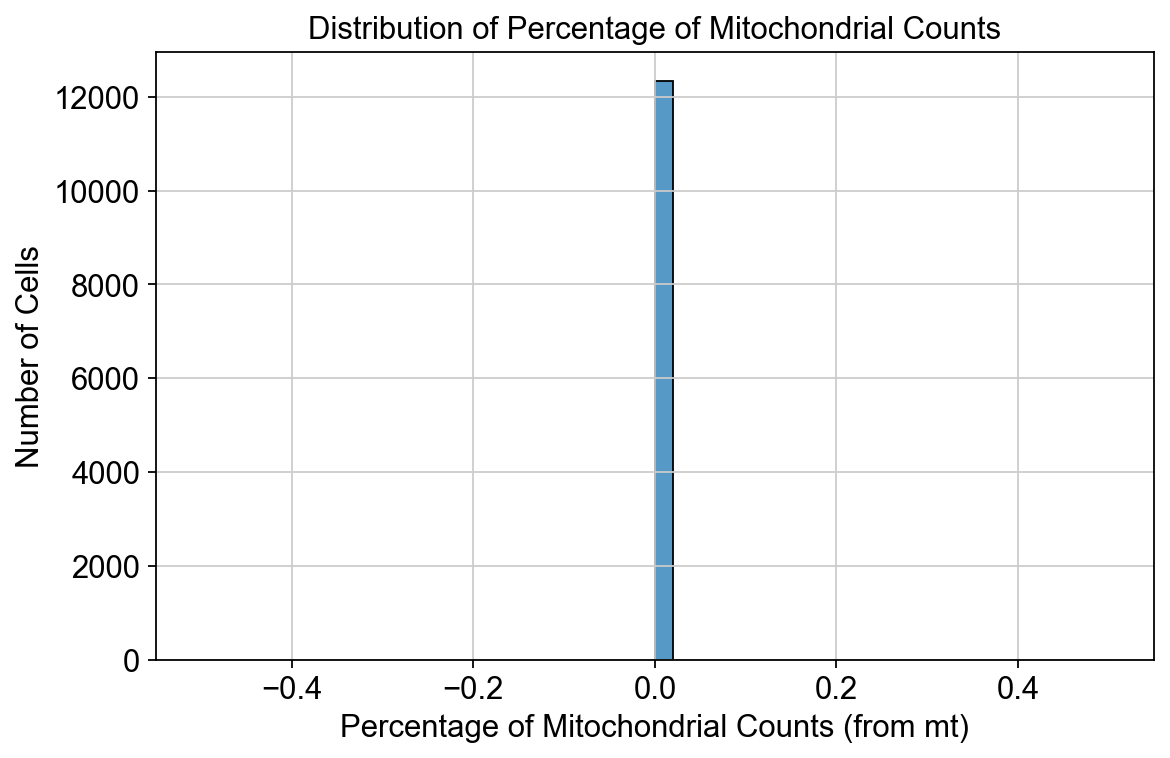


Visualizing QC metrics...
Plotting violin plots for n_genes_by_counts, total_counts, and pct_counts_mt...


/Users/mrrobot/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/mx/ttczf76577z53ygmmv93kfzw0000gn/T/ipykernel_74067/1928005851.py:134: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


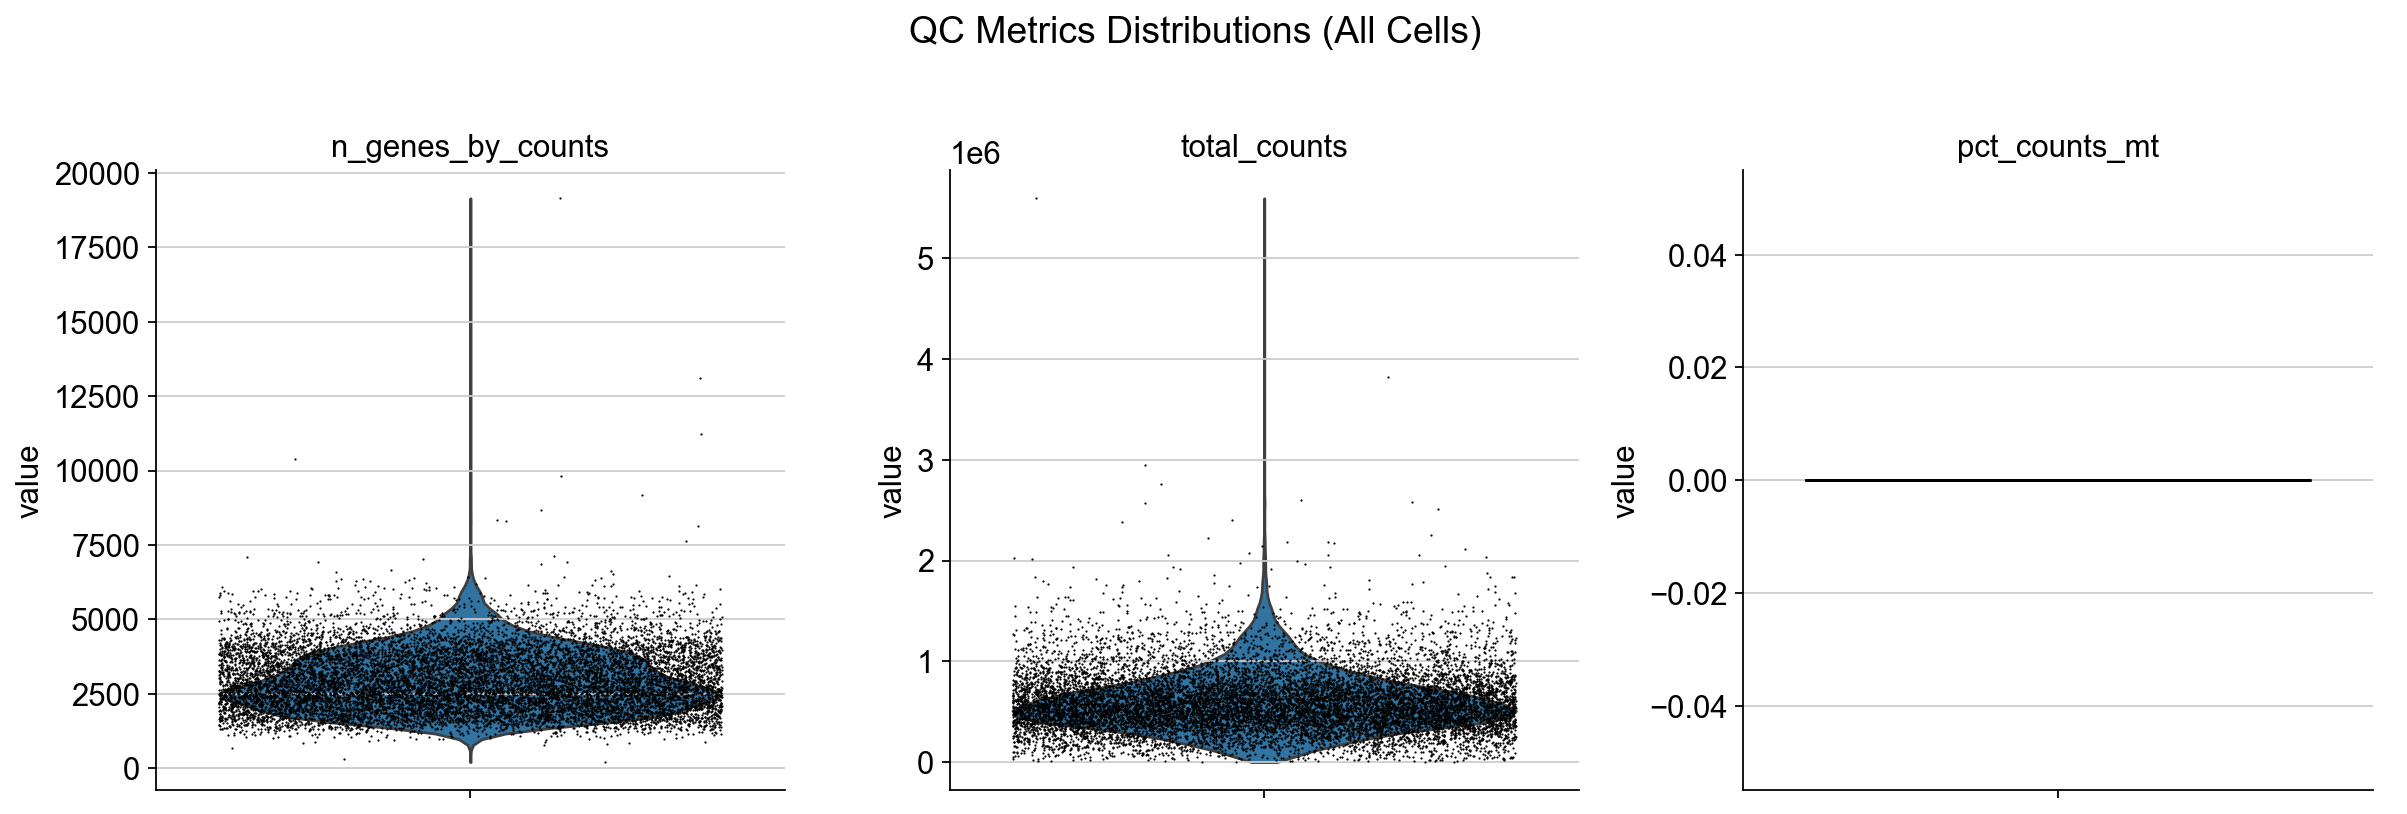


Plotting violin plots grouped by 'tissue_origin'...


/var/folders/mx/ttczf76577z53ygmmv93kfzw0000gn/T/ipykernel_74067/1928005851.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


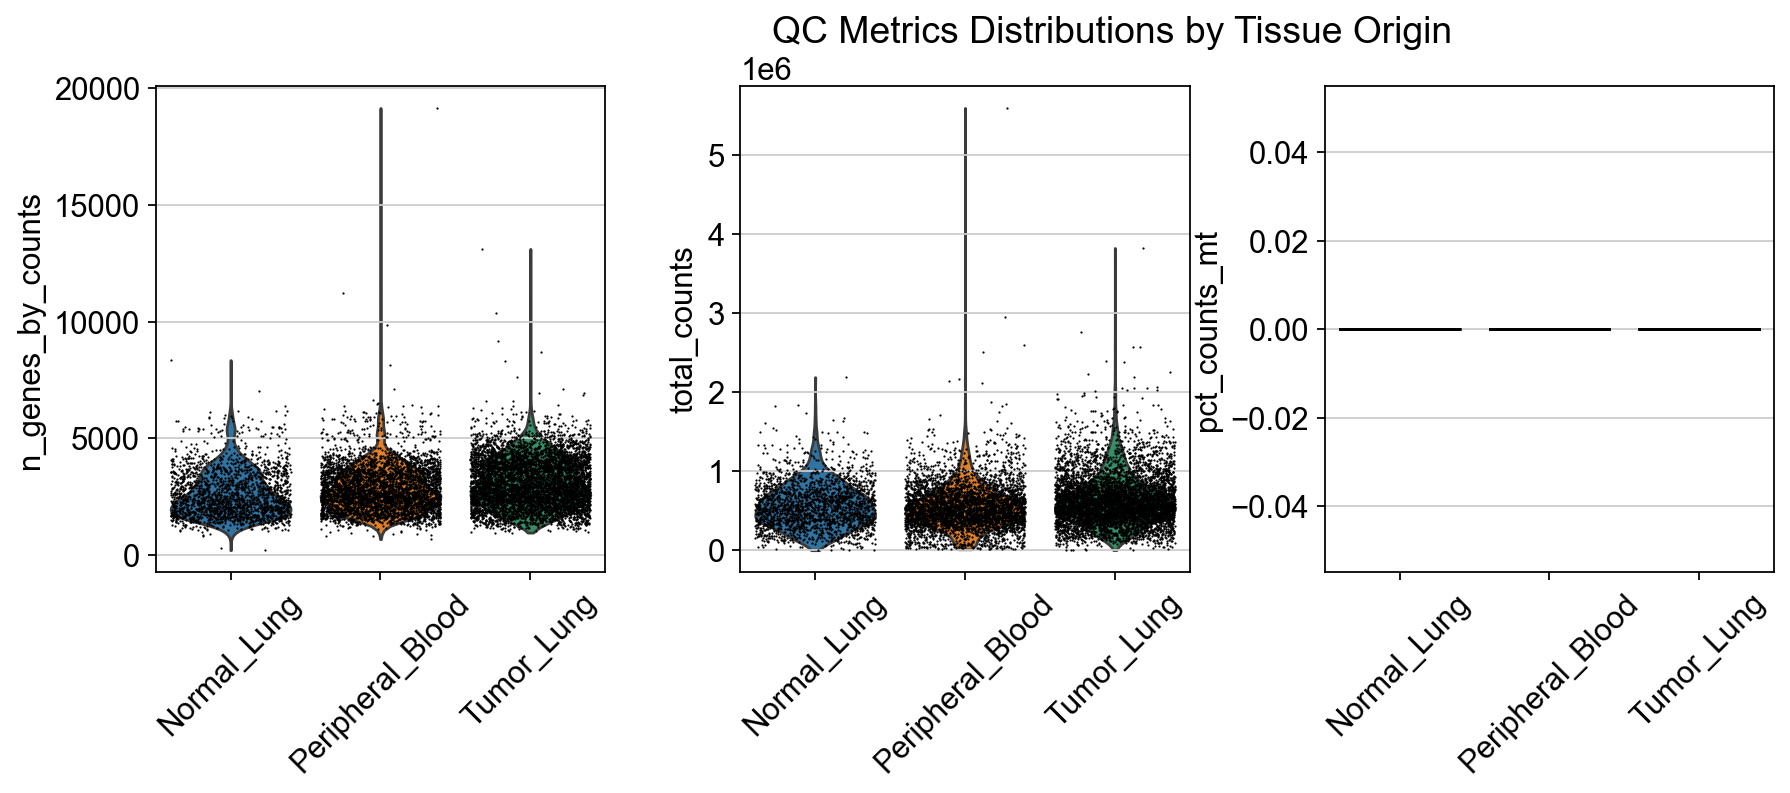


Plotting scatter plots for QC metric relationships...


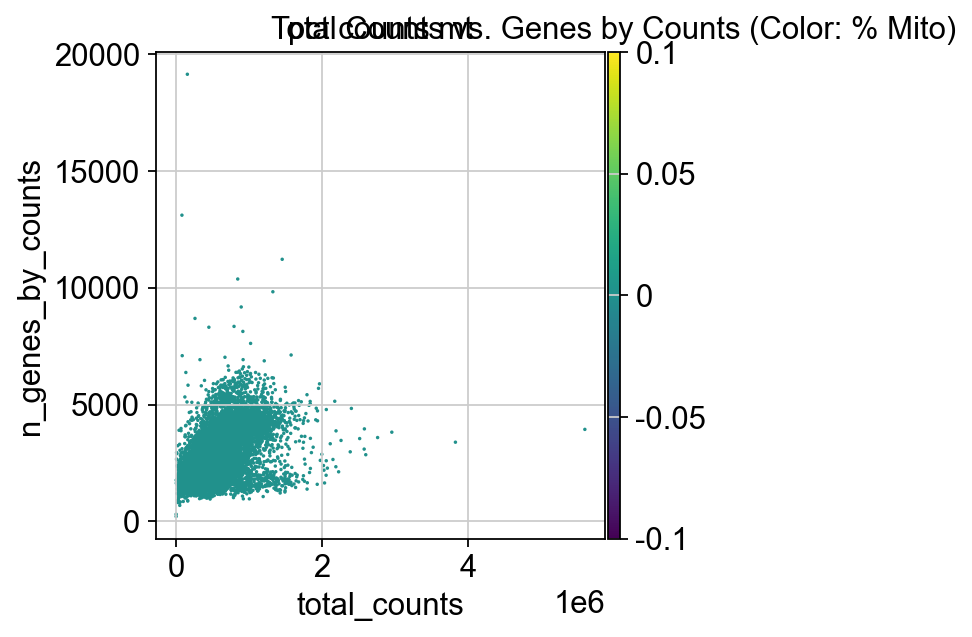

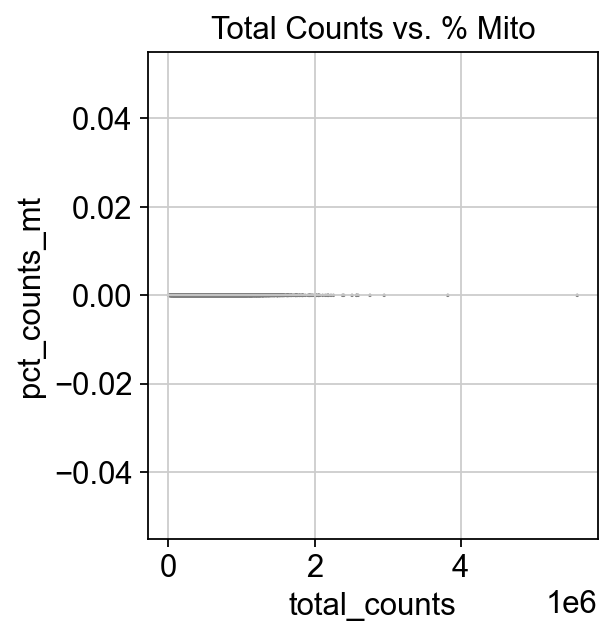

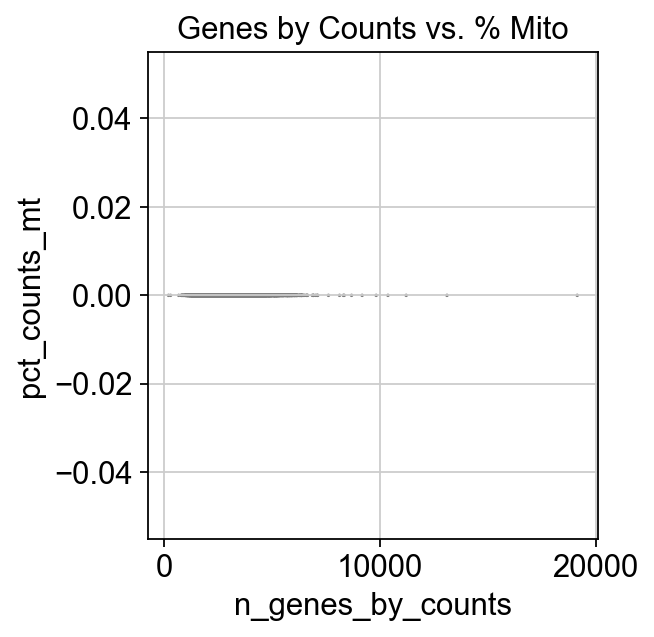

In [5]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set scanpy plotting settings for better aesthetics (optional)
sc.settings.set_figure_params(dpi=80, facecolor='white')

# --- 1. Define File Paths ---
project_dir = '/Users/mrrobot/Projects_/EDA_dashboard_GEO_dataset' # Adjust if your notebook is elsewhere
processed_data_dir = os.path.join(project_dir, 'data', 'processed')

counts_file_path = os.path.join(processed_data_dir, 'counts_matrix_raw.csv.gz')
metadata_file_path = os.path.join(processed_data_dir, 'cell_metadata_basic.csv')

# --- 2. Load Data ---
counts_df = None
basic_metadata_df = None
adata = None # Initialize adata to None

try:
    print(f"Attempting to load counts from: {counts_file_path}")
    counts_df = pd.read_csv(counts_file_path, index_col=0, compression='gzip')
    
    print(f"Attempting to load metadata from: {metadata_file_path}")
    basic_metadata_df = pd.read_csv(metadata_file_path, index_col=0)

    print("\nSuccessfully loaded counts_df and basic_metadata_df.")
    print(f"counts_df shape: {counts_df.shape}")
    print(f"basic_metadata_df shape: {basic_metadata_df.shape}")

    # --- 3. Create AnnData Object ---
    aligned_metadata_df = basic_metadata_df.loc[counts_df.columns] 
    adata = sc.AnnData(X=counts_df.T, obs=aligned_metadata_df)
    print("\nSuccessfully created AnnData object.")
    print(adata)
    
    adata.var_names_make_unique()
    print("\nMade var_names (gene names) unique.")

    # --- 4. Identify Mitochondrial Genes & Calculate QC ---
    print("\n--- Attempting to identify mitochondrial genes and calculate QC metrics ---")
    
    # Option 1: Using a predefined list (if you identify the exact names)
    # Replace this list with the actual mitochondrial gene names found in your data
    # For example, if your CLI search showed 'MTND1', 'MTCO1', etc. (no hyphen)
    # actual_mito_genes = ['MTND1', 'MTND2', 'MTND3', 'MTND4', 'MTND4L', 'MTND5', 'MTND6', 
    #                      'MTCO1', 'MTCO2', 'MTCO3', 'MTCYB', 'MTATP6', 'MTATP8', 
    #                      'MTRNR1', 'MTRNR2']
    # If they had hyphens like 'MT-ND1', use that list.
    
    # For now, since we haven't confirmed the exact names from your CLI output yet,
    # let's create an 'mt' column. If we can't find any, pct_counts_mt will be 0.
    # This allows the calculate_qc_metrics function to run without erroring on a missing qc_var.
    
    # Placeholder: Try to find genes starting with 'MT-' as a first pass
    # This didn't work before, but we need an 'mt' column for calculate_qc_metrics
    adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
    num_mt_genes_found = adata.var['mt'].sum()
    
    if num_mt_genes_found == 0:
        print("WARNING: No genes found starting with 'MT-'. Trying 'MT' (no hyphen) for canonical mitochondrial genes.")
        # Attempt with no hyphen for the 15 canonical MT genes
        mito_genes_no_hyphen = [
            'MTND1', 'MTND2', 'MTND3', 'MTND4', 'MTND4L', 'MTND5', 'MTND6', 
            'MTCO1', 'MTCO2', 'MTCO3', 'MTCYB', 'MTATP6', 'MTATP8',
            'MTRNR1', 'MTRNR2'
        ]
        adata.var['mt'] = adata.var_names.isin(mito_genes_no_hyphen)
        num_mt_genes_found = adata.var['mt'].sum()
        if num_mt_genes_found == 0:
            print("WARNING: Still no canonical mitochondrial genes found (even without hyphens).")
            print("`pct_counts_mt` will be 0. You MUST resolve mitochondrial gene identification for meaningful QC.")
        else:
            print(f"Found {num_mt_genes_found} mitochondrial genes using non-hyphenated canonical list.")
            print(f"Identified MT genes: {adata.var_names[adata.var['mt']].tolist()}")
    else:
        print(f"Found {num_mt_genes_found} mitochondrial genes using 'MT-' prefix.")
        print(f"Identified MT genes: {adata.var_names[adata.var['mt']].tolist()}")

    # Calculate QC metrics using scanpy's built-in function
    sc.pp.calculate_qc_metrics(
        adata, 
        qc_vars=['mt'], # This will use the 'mt' column defined above
        percent_top=None,
        log1p=False,
        inplace=True
    )
    # This adds 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt' to adata.obs
    
    print("\nSuccessfully calculated QC metrics.")
    print("First 5 rows of adata.obs (cell metadata with QC metrics):")
    print(adata.obs.head())

    # --- Diagnostic checks for 'pct_counts_mt' ---
    print("\nDescriptive statistics for 'pct_counts_mt':")
    print(adata.obs['pct_counts_mt'].describe())

    plt.figure(figsize=(8, 5))
    sns.histplot(adata.obs['pct_counts_mt'], bins=50, kde=False)
    plt.title('Distribution of Percentage of Mitochondrial Counts')
    plt.xlabel('Percentage of Mitochondrial Counts (from mt)')
    plt.ylabel('Number of Cells')
    plt.show()
    
except FileNotFoundError as e:
    print(f"File Not Found Error: {e}. Please ensure you saved the files from Notebook 01 into the 'data/processed/' directory.")
    adata = None 
except KeyError as e:
    print(f"KeyError during AnnData creation, alignment, or QC: {e}.")
    print("This often means cell IDs in metadata don't match counts_df columns, or a required column is missing.")
    adata = None 
except Exception as e:
    print(f"An general error occurred during data loading or initial QC setup: {e}")
    adata = None 

# --- 5. Visualize QC Metrics ---
# This section should now work if adata and its .obs columns are correctly populated
if 'adata' in locals() and adata is not None and 'n_genes_by_counts' in adata.obs.columns and 'total_counts' in adata.obs.columns and 'pct_counts_mt' in adata.obs.columns:
    print("\nVisualizing QC metrics...")

    # A. Violin plots
    print("Plotting violin plots for n_genes_by_counts, total_counts, and pct_counts_mt...")
    sc.pl.violin(
        adata,
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
        jitter=0.4,
        multi_panel=True,
        show=False
    )
    plt.suptitle('QC Metrics Distributions (All Cells)', y=1.02)
    plt.tight_layout()
    plt.show()

    # Violin plots grouped by 'tissue_origin'
    print("\nPlotting violin plots grouped by 'tissue_origin'...")
    sc.pl.violin(
        adata,
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
        jitter=0.4,
        groupby='tissue_origin',
        rotation=45,
        multi_panel=True,
        show=False
    )
    plt.suptitle('QC Metrics Distributions by Tissue Origin', y=1.02)
    plt.tight_layout()
    plt.show()

    # B. Scatter plots
    print("\nPlotting scatter plots for QC metric relationships...")
    
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt', show=False) 
    plt.title('Total Counts vs. Genes by Counts (Color: % Mito)')
    plt.show()

    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', show=False) 
    plt.title('Total Counts vs. % Mito')
    plt.show()
    
    sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt', show=False) 
    plt.title('Genes by Counts vs. % Mito')
    plt.show()

else:
    print("\nAnnData object 'adata' is not defined, was not successfully processed, or key QC metric columns are missing from adata.obs. Cannot visualize QC metrics.")
    if 'adata' in locals() and adata is not None:
        print("Current columns in adata.obs:", list(adata.obs.columns))

Attempting to load counts from: /Users/mrrobot/Projects_/EDA_dashboard_GEO_dataset/data/processed/counts_matrix_raw.csv.gz
Attempting to load metadata from: /Users/mrrobot/Projects_/EDA_dashboard_GEO_dataset/data/processed/cell_metadata_basic.csv

Successfully loaded counts_df and basic_metadata_df.
counts_df shape: (23459, 12346)
basic_metadata_df shape: (12346, 3)

Successfully created AnnData object.
AnnData object with n_obs × n_vars = 12346 × 23459
    obs: 'sample_type_prefix', 'tissue_origin', 'patient_id'

Made var_names (gene names) unique.


/Users/mrrobot/anaconda3/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/mrrobot/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")



Visualizing QC metrics (excluding mitochondrial percentage for now)...


KeyError: "Could not find keys ['n_genes_by_counts', 'total_counts'] in columns of `adata.obs` or in adata.var_names."

In [8]:
if num_mt_genes_found == 0:
        print("WARNING: No genes found starting with 'MT-'. Trying 'MT' (no hyphen) for canonical mitochondrial genes.")
        # ... tries non-hyphenated list ...
        if num_mt_genes_found == 0:
            print("WARNING: Still no canonical mitochondrial genes found (even without hyphens).")
            print("`pct_counts_mt` will be 0. You MUST resolve mitochondrial gene identification for meaningful QC.")
        else:
            print(f"Found {num_mt_genes_found} mitochondrial genes using non-hyphenated canonical list.")
            print(f"Identified MT genes: {adata.var_names[adata.var['mt']].tolist()}")
else:
        print(f"Found {num_mt_genes_found} mitochondrial genes using 'MT-' prefix.")
        print(f"Identified MT genes: {adata.var_names[adata.var['mt']].tolist()}")

`pct_counts_mt` will be 0. You MUST resolve mitochondrial gene identification for meaningful QC.



Visualizing QC metrics...
Plotting violin plots for n_genes_by_counts, total_counts, and pct_counts_mt...


/Users/mrrobot/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/mx/ttczf76577z53ygmmv93kfzw0000gn/T/ipykernel_74067/372591372.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


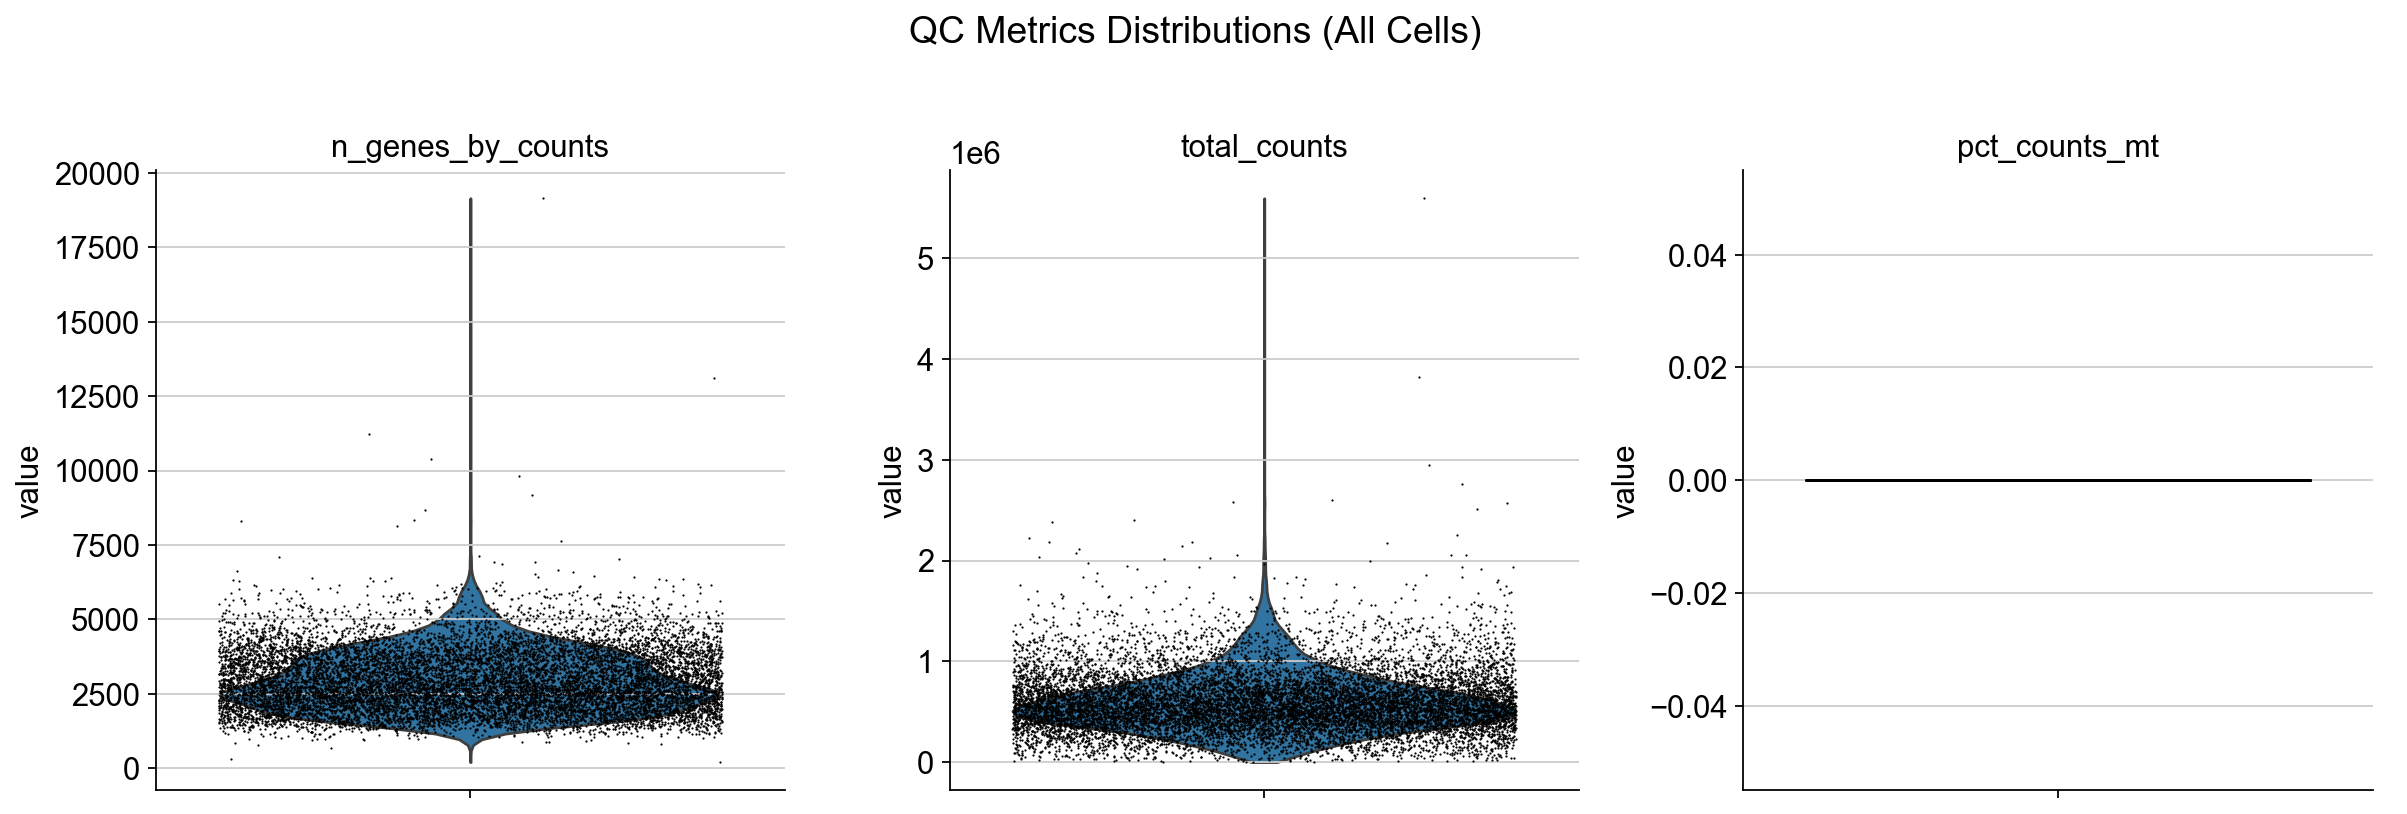


Plotting violin plots grouped by 'tissue_origin'...


/var/folders/mx/ttczf76577z53ygmmv93kfzw0000gn/T/ipykernel_74067/372591372.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


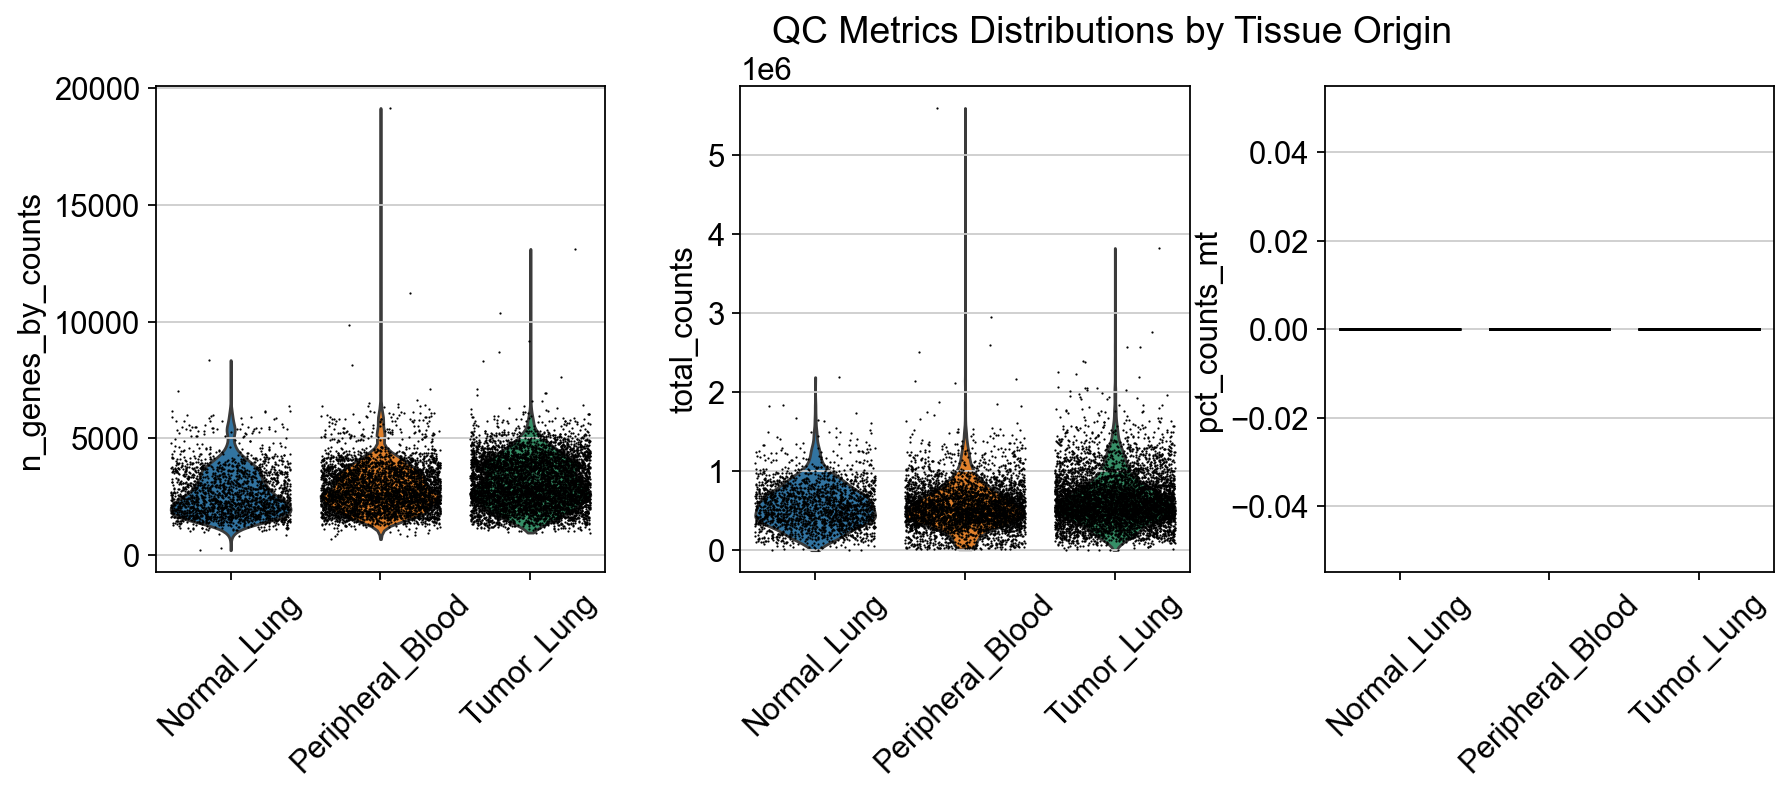


Plotting scatter plots for QC metric relationships...


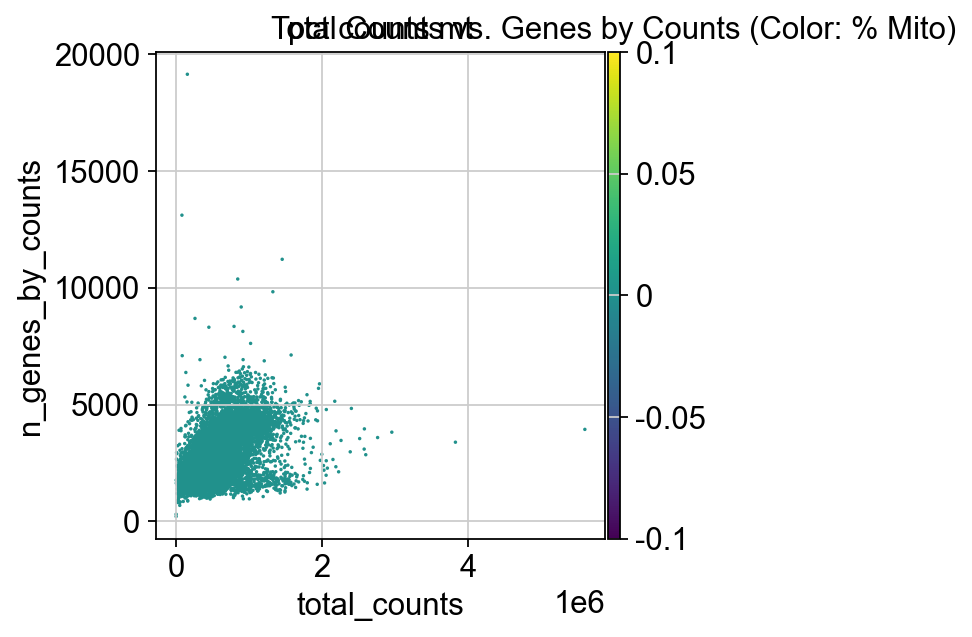

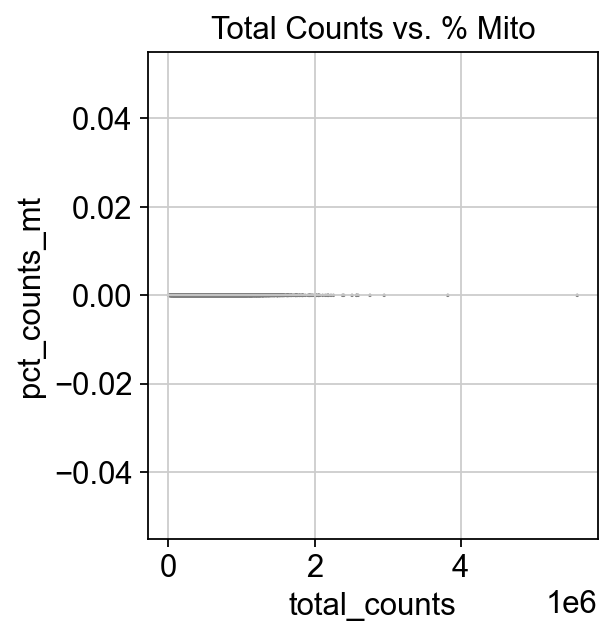

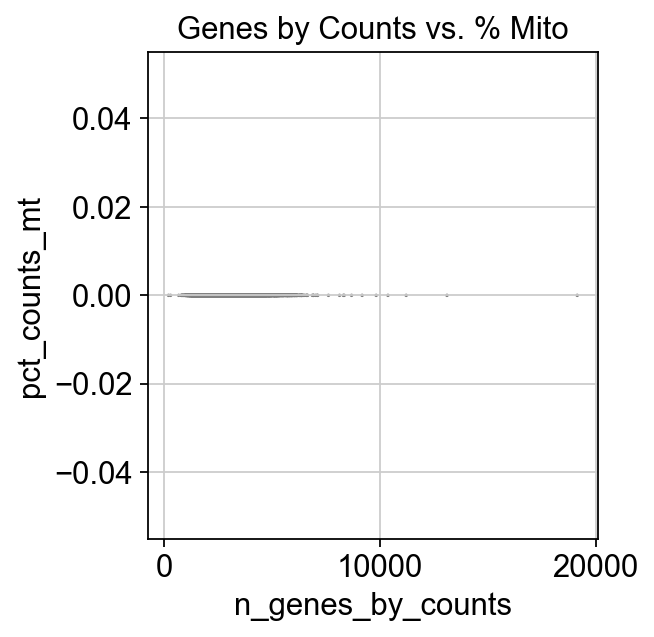

In [9]:
if 'adata' in locals() and adata is not None and 'n_genes_by_counts' in adata.obs.columns and 'total_counts' in adata.obs.columns and 'pct_counts_mt' in adata.obs.columns:
    print("\nVisualizing QC metrics...")

    # A. Violin plots
    print("Plotting violin plots for n_genes_by_counts, total_counts, and pct_counts_mt...")
    sc.pl.violin(
        adata,
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
        jitter=0.4,
        multi_panel=True,
        show=False
    )
    plt.suptitle('QC Metrics Distributions (All Cells)', y=1.02)
    plt.tight_layout()
    plt.show()

    # Violin plots grouped by 'tissue_origin'
    print("\nPlotting violin plots grouped by 'tissue_origin'...")
    sc.pl.violin(
        adata,
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
        jitter=0.4,
        groupby='tissue_origin',
        rotation=45,
        multi_panel=True,
        show=False
    )
    plt.suptitle('QC Metrics Distributions by Tissue Origin', y=1.02)
    plt.tight_layout()
    plt.show()

    # B. Scatter plots
    print("\nPlotting scatter plots for QC metric relationships...")
    
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt', show=False) 
    plt.title('Total Counts vs. Genes by Counts (Color: % Mito)')
    plt.show()

    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', show=False) 
    plt.title('Total Counts vs. % Mito')
    plt.show()
    
    sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt', show=False) 
    plt.title('Genes by Counts vs. % Mito')
    plt.show()

else:
    print("\nAnnData object 'adata' is not defined, was not successfully processed, or key QC metric columns are missing from adata.obs. Cannot visualize QC metrics.")
    if 'adata' in locals() and adata is not None:
        print("Current columns in adata.obs:", list(adata.obs.columns))
